# Object Detection by Image Segmentation
## Tugas Mata Kuliah: Computer Vision Lanjut
Risang Panggalih 24/550961/PPA/06961

## Otsu Method
Metode segmentasi citra yang digunakan adalah Otsu Thresholding untuk memisahkan objek (foreground) dan latar belakang (background) berdasarkan distribusi intensitas pixel.

In [128]:
# Import Library

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [129]:
# Load dataset
img_rgb = Image.open("image.jpg").convert("RGB")
mask_img = Image.open("image_mask.jpg").convert("L")

img_rgb = np.array(img_rgb)
mask_arr = np.array(mask_img)

In [130]:
# Utils

def rgb_to_gray(arr):
    if arr.ndim == 2:
        return arr.astype(np.float32)
    r, g, b = arr[...,0].astype(np.float32), arr[...,1].astype(np.float32), arr[...,2].astype(np.float32)
    return 0.299*r + 0.587*g + 0.114*b

def ensure_binary_mask(arr):
    if arr.ndim == 3:
        arr = rgb_to_gray(arr)
    arr = arr.astype(np.float32)
    return (arr > 127).astype(np.uint8)

Citra input diubah menjadi grayscale, kemudian nilai ambang optimal ditentukan dengan memaksimalkan varian antar kelas (inter-class variance).

In [131]:
# Otsu Threshold

def otsu_threshold(gray):
    gray = gray.astype(np.float32)
    hist, _ = np.histogram(gray, bins=256, range=(0,256))
    p = hist / gray.size
    omega = np.cumsum(p) # probabilitas class
    mu = np.cumsum(p * np.arange(256)) # mean class
    mu_t = mu[-1] # total mean
    # between-class variance
    denom = (omega * (1.0 - omega))
    denom[denom == 0] = 1e-12
    sigma_b2 = (mu_t*omega - mu)**2 / denom
    t = int(np.nanargmax(sigma_b2))
    return t

def segment_otsu(img_rgb):
    gray = rgb_to_gray(img_rgb) # float32
    t = otsu_threshold(gray)
    seg = (gray >= t).astype(np.uint8)
    return seg, t

In [132]:
# Metrics

def pixel_accuracy(pred, gt):
    return np.mean((pred == gt).astype(np.float32))

def iou(pred, gt):
    inter = np.logical_and(pred==1, gt==1).sum()
    union = np.logical_or(pred==1, gt==1).sum()
    return inter / (union + 1e-12)

In [133]:
pred_mask, thresh = segment_otsu(img_rgb)
gray_img = rgb_to_gray(img_rgb)

Hasil segmentasi dibandingkan dengan ground truth mask untuk menghitung akurasi pixel dan nilai IoU (Intersection over Union).

In [134]:
if mask_arr is not None:
    gt_mask = ensure_binary_mask(mask_arr)
    if gt_mask.shape != pred_mask.shape:
        raise ValueError(f"Ukuran mask {gt_mask.shape} harus sesuai ukuran citra {pred_mask.shape}.")

    acc = pixel_accuracy(pred_mask, gt_mask)
    iou_val = iou(pred_mask, gt_mask)
    print(f"Pixel Accuracy: {acc:.4f}")
    print(f"IoU: {iou_val:.4f}")
else:
    print("Tidak ada ground truth (image_mask.png)")

Pixel Accuracy: 0.9588
IoU: 0.9459


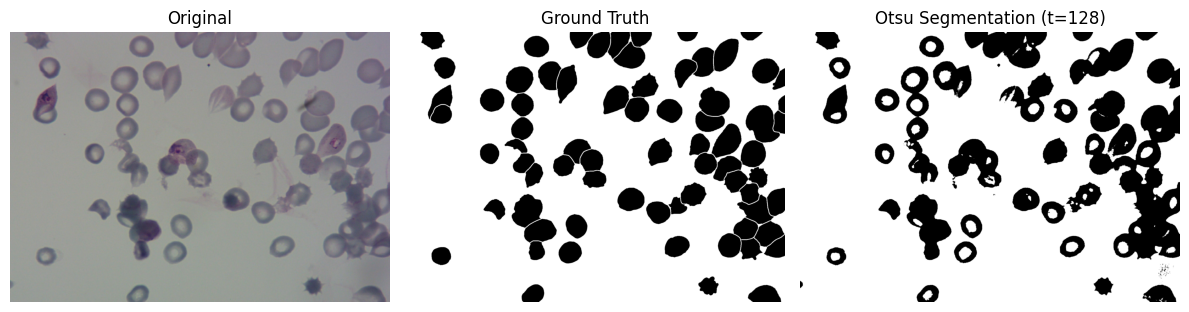

In [135]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(img_rgb)
axs[0].set_title("Original")
axs[0].axis("off")
axs[1].imshow(gt_mask, cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Ground Truth")
axs[1].axis("off")
axs[2].imshow(pred_mask, cmap="gray", vmin=0, vmax=1)
axs[2].set_title(f"Otsu Segmentation (t={thresh})")
axs[2].axis("off")

plt.tight_layout()
plt.show()

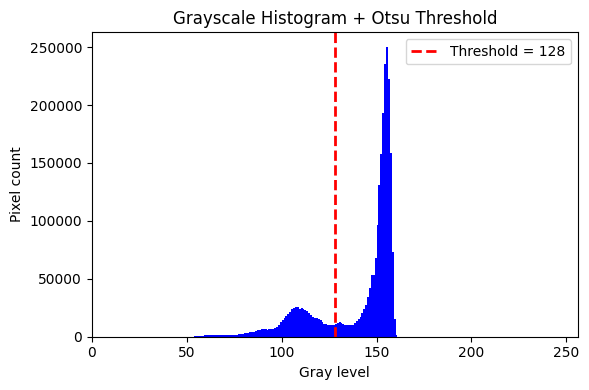

In [136]:
plt.figure(figsize=(6,4))
plt.hist(gray_img.ravel(), bins=256, range=(0,256), color="blue")
plt.axvline(thresh, color="red", linestyle="--", linewidth=2, label=f"Threshold = {thresh}")
plt.title("Grayscale Histogram + Otsu Threshold")
plt.xlabel("Gray level")
plt.ylabel("Pixel count")
plt.legend()
plt.xlim(0, 256)
plt.tight_layout()
plt.show()